The input of the NN is 1D. 

In [1]:
import numpy as np
import copy
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
from torch.nn.functional import normalize
from sklearn.model_selection import train_test_split
from torch.nn.functional import normalize
import matplotlib.pyplot as plt

def quad_fn(a, b, c, x):
    return a*x**2 + b*x + c

def x_square(x: torch.tensor) -> torch.Tensor:
    return x**2

# DEFINE GIVEN FUNCTION V(x): ax^2 + bx + c
given_fn = x_square

In [46]:
# CUSTOM LOSS FUNCTION:
# def EpsilonLoss(nn.Module):

def epsilon_Loss(v_x, model_u, lower_bound, upper_bound, n_points):
    """
    GOAL: Epsilon function evaluated at u using discretized estimation
    minimizing Epsilon(u) = 
    
    ARGS: 
    n_points (int): number of discretized points on the interval [-L, L]
    e.g.: -(L)|---|---|---|---|(L) interval has n_points = 5

    v_x (torch.Tensor): function instance
    model_u (torch.Tensor): model output
    """
    total = 0
    discrete_points = np.linspace(lower_bound, upper_bound, n_points)
    h = discrete_points[1] - discrete_points[0]
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        u_xi = model_u(x_i)

        u_prime = model_u.u_prime_2(x_i)
        
        v_xi = v_x(x_i)
        t = torch.abs(torch.square(u_prime)) + v_xi*(u_xi**2)
        total += t
    return 0.5*h*total

def epsilon_Loss_penalty(v_x, model_u, lambda_pen,
                         lower_bound, upper_bound, n_points):
    """
    
    """
    eps_sum = 0
    pen = 0

    discrete_points = np.linspace(lower_bound, upper_bound, n_points)
    h = discrete_points[1] - discrete_points[0]
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        u_prime = model_u.u_prime_2(x_i)
        
        u_xi = model_u(x_i)
        v_xi = v_x(x_i)

        t = torch.abs(torch.square(u_prime)) + v_xi*torch.square(u_xi)
        eps_sum += t
    epsilon_fn = 0.5*h*eps_sum
    
    temp = 0
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        temp += torch.square(model_u(x_i))
    
    pen = lambda_pen * torch.square((h * temp-1))
    return epsilon_fn + pen 

# NORMALIZE MODEL u(x) OUTPUT:
def normalize_u(model_u, lower_bound, upper_bound, n_points):
    """
    Normalize model.output weight by: 
    model.output *= c
    where,
    scalar c = 1/denom
    """
    discrete_points = np.linspace(lower_bound, upper_bound, n_points)
    h = discrete_points[1] - discrete_points[0]
    s = 0
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        s += model_u(x_i)**2
    denom = math.sqrt(h) * torch.sqrt(s)
    return 1/denom

### Testing Function

In [9]:
t_model = Nonlinear(3)

In [27]:
normalize_u(t_model, lb, ub, npoints)

tensor([1.], grad_fn=<MulBackward0>)

In [28]:
print(t_model.hidden.weight.data)
print(t_model.hidden.bias.data)
print('--')
print(t_model.output.weight.data)
print(t_model.output.bias.data)

tensor([[ 0.5273],
        [-0.7745],
        [-0.6989]])
tensor([-0.1022, -0.7966,  0.2270])
--
tensor([[-0.1464, -0.0825, -0.1300]])
tensor([0.6164])


In [32]:
t_input = torch.tensor([2], requires_grad=True, dtype=torch.float)

In [45]:
type(t_model(t_input))

torch.Tensor

In [29]:
t_model(t_input).backward()

In [ ]:
t_model.epsilon_loss_

In [8]:
lb = -2
ub = 2
npoints = 5
np.linspace(lb, ub, npoints)

array([-2., -1.,  0.,  1.,  2.])

In [47]:
# CREATING MODEL CLASS
class Nonlinear(nn.Module):
    def __init__(self, n):
        # One hidden layer with n nodes
        super().__init__()
        self.hidden = nn.Linear(1, n)
        self.output = nn.Linear(n, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.target_fn = given_fn

    def forward(self, x, use_tanh_fn = False):
        if use_tanh_fn == True:
            x = self.hidden(x)
            x = self.tanh(x)
            x = self.output(x)
        else:
            x = self.hidden(x)
            x = self.sigmoid(x)
            x = self.output(x)
        return x

    def normalize_model(self, lower_bound, upper_bound, n_points):
        """
        GOAL: Normalize the output weight layer
        """
        print("Before normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        
        c = normalize_u(self, lower_bound, upper_bound, n_points)
        self.output.weight.data.copy_(c.item() * self.output.weight.data)
        self.output.bias.data.copy_(c.item() * self.output.bias.data)

        print("After normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        print("c value = " + str(c))

        return 

    def u_prime_2(self, input):
        i_tensor = torch.tensor([input.item()], requires_grad=True, dtype=torch.float)
        clone_model = copy.deepcopy(self)
        res = clone_model(i_tensor)
        res.backward()
        
        val = 0
        val += i_tensor.grad

        del i_tensor
        del clone_model
        
        return val

    def u_prime(self, input):
        """
        NN with 1 hidden node layer is of the form:
        u(x) = SUM_i_to_N(a_i * sigmoid(w.x + b))

        where
        a_i is the corresponding weight of self.output layerq
        w is self.hidden.weight vector
        b is self.hidden.bias vector
        sigmoid(w.x + b) is the sigmoid-activated hidden vector

        Formula of u'(x) (for 1 hidden layer NN):
        u'(x) = SUM_i_to_N(w_i*a_i*sigmoid'(w_i*x+b))
        Note: sigmoid'(w_i*x +b) = sigmoid(w_i*x+b)*(1-sigmoid(w_i*x+b))
        """
        a_i = self.output.weight.data
        w_i = torch.transpose(self.hidden.weight.data, 0, 1)
        wi_ai = w_i * a_i

        hid_layer = self.hidden(input)
        hid_layer_T = torch.reshape(hid_layer, (list(hid_layer.shape)[0], 1))
        m = hid_layer_T * (1-hid_layer_T)

        return wi_ai @ m
    
# TRANING MODEL
    def train_network_with_penalty(self, num_epochs, v_x, optimizer, lambda_pen,
                                    lower_bound, upper_bound, n_points):
        # For plotting loss value over epochs:
        x_epochs = []
        y_loss = []
        y_loss_pen = []

        # stopping criterion:
        stop_counter = 0

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            loss_pen = epsilon_Loss_penalty(v_x, self, lambda_pen,
                                        lower_bound, upper_bound, n_points)
            loss = epsilon_Loss(v_x, self,
                                lower_bound, upper_bound, n_points)
            
            y_loss_pen.append(loss_pen.detach().numpy().item())
            y_loss.append(loss.detach().numpy().item())
            x_epochs.append(epoch)

            #check if need to stop training:
            if epoch > 0 and stop_counter >= 5:

                #Normalize model before return
                self.normalize_model(lower_bound, upper_bound, n_points)

                print("LOSS VALUE WITH LAMBDA PENALTY = " 
                      + str(epsilon_Loss_penalty(v_x, self, lambda_pen,
                                                 lower_bound, upper_bound, n_points)))
                print("LOSS VALUE  = " 
                      + str(epsilon_Loss(v_x, self, lower_bound, upper_bound, n_points)))
                
                break
            elif epoch > 0 and stop_counter < 5:
                if torch.abs(y_loss_pen[epoch-1]-loss_pen) <= 1e-5:
                    stop_counter += 1
                else:
                    stop_counter = 0
            else:
                print("Uncatched case")

            print('epoch {}, loss with penalty {}'.format(epoch, loss_pen.item()))
            loss_pen.backward()
            optimizer.step()

        return (x_epochs, y_loss_pen, y_loss)

    def train_network(self, num_epochs, v_x, optimizer,
                                    lower_bound, upper_bound, n_points):
        # For plotting loss value over epochs:
        x_epochs = []
        y_loss = []
        
        # stopping criterion:
        stop_counter = 0

        for epoch in range(num_epochs):

            if epoch > 0 and epoch % 50 == 0:
                c = normalize_u(self, lower_bound, upper_bound, n_points)
                print("Pre normalize: ")
                print(self.output.weight.data)
                print(self.output.bias.data)
                print("After normalize: ")
                
                self.normalize_model(lower_bound, upper_bound, n_points)
                
                print(self.output.weight.data)
                print(self.output.bias.data)
                print("c value = " + str(c))
            optimizer.zero_grad()
            loss = epsilon_Loss(v_x, self,
                                lower_bound, upper_bound, n_points)
            y_loss.append(loss.detach().numpy().item())
            x_epochs.append(epoch)
            #check if need to stop training:
            if epoch > 0 and stop_counter >= 5:
                print("LOSS VALUE = " 
                      + str(epsilon_Loss(v_x, self, lower_bound, upper_bound, n_points)))
                break
            elif epoch > 0 and stop_counter < 5:
                if torch.abs(y_loss[epoch-1]-loss) <= 1e-5:
                    stop_counter += 1
                else:
                    stop_counter = 0

            print('epoch {}, loss {}'.format(epoch, loss.item()))
            loss.backward()
            optimizer.step()

        return (x_epochs, y_loss)
        

In [48]:
# DEFINE HYPER-PARAMETERS
batch_size = 50
learningRate = 0.05
num_epochs = 2000

#INIT MODEL
model = Nonlinear(20)
if torch.cuda.is_available():
    model.cuda()

# INIT OPTIMIZER CLASS
# What is an optimizer: 
# SGD:
# SGD_optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
# Adam:
adam_optimizer = torch.optim.Adam(model.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

# INIT LOSS FUNCTION: MSE
# criterion = epsilon_Loss

In [40]:
INPUT_SIZE = 1
OUTPUT_SIZE = 1

LAMBDA_PEN = 100
LOWER_BOUND = -6
UPPER_BOUND = 6
N_POINTS = 100

# CREATING DATASET:
x_values = [i for i in np.linspace(LOWER_BOUND, UPPER_BOUND, N_POINTS)]
y_values = [given_fn(i) for i in x_values]

x_train = np.array(x_values, dtype=np.float32).reshape(-1, 1)
y_train = np.array(y_values, dtype=np.float32).reshape(-1, 1)

print(x_train.shape, y_train.shape)

(100, 1) (100, 1)


In [49]:
model_2 = Nonlinear(20)
adam_optimizer_2 = torch.optim.Adam(model_2.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)


In [41]:
# PLOT DATA
def plot_figure(x_val, y_val, x_test=None, predicted=None):
    plt.clf()
    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(x_val, y_val, '--', label='True data', alpha=0.5)
    if predicted != None:
        plt.plot(x_test, predicted, '--', label='Predictions', alpha=0.5)
    plt.legend(loc='best')
    plt.show()

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [34]:
#SAVE MODEL TO DRIVE
model_save_name = 'latest_model.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
#LOAD MODEL FROM DRIVE
model_save_name = 'latest_model.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

In [54]:
graph_val_pen = model.train_network_with_penalty(num_epochs, given_fn, adam_optimizer, LAMBDA_PEN, LOWER_BOUND, UPPER_BOUND, N_POINTS)

Uncatched case
epoch 0, loss with penalty 790.7296752929688
epoch 1, loss with penalty 94.28144073486328
epoch 2, loss with penalty 273.4927978515625
epoch 3, loss with penalty 967.3690185546875
epoch 4, loss with penalty 94.94194030761719
epoch 5, loss with penalty 29.147310256958008
epoch 6, loss with penalty 95.31737518310547
epoch 7, loss with penalty 82.80135345458984
epoch 8, loss with penalty 25.100452423095703
epoch 9, loss with penalty 17.648544311523438
epoch 10, loss with penalty 144.3861846923828
epoch 11, loss with penalty 223.99412536621094
epoch 12, loss with penalty 113.25946807861328
epoch 13, loss with penalty 17.11690902709961
epoch 14, loss with penalty 11.777090072631836
epoch 15, loss with penalty 40.03099060058594
epoch 16, loss with penalty 65.20401763916016
epoch 17, loss with penalty 80.63245391845703
epoch 18, loss with penalty 88.79216766357422
epoch 19, loss with penalty 92.64260864257812
epoch 20, loss with penalty 94.01604461669922
epoch 21, loss with pen

In [ ]:
graph_val = model_2.train_network(num_epochs, given_fn, adam_optimizer_2, LOWER_BOUND, UPPER_BOUND, N_POINTS)

Penalty lambda value = 100
Interval is [-6, 6], with N_POINTS = 100


Plot 1: The epsilon_loss_with_penalty along the training epochs:


<Figure size 432x288 with 0 Axes>

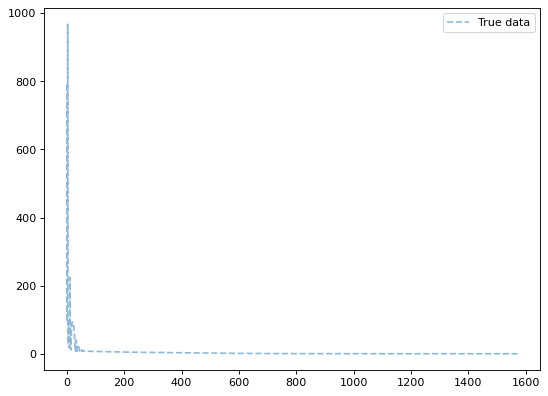



Plot 2: The epsilon_loss value along the training epochs:


<Figure size 432x288 with 0 Axes>

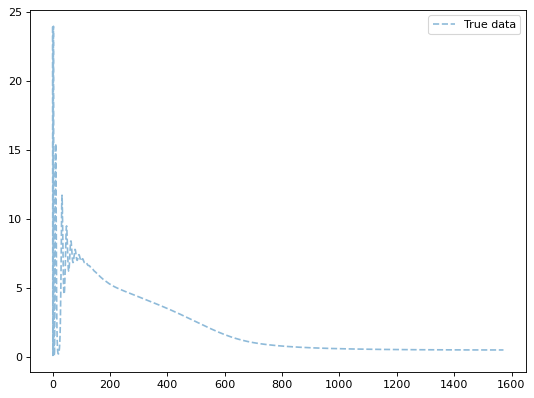



Plot 3: the model's output with input from the interval: 


<Figure size 432x288 with 0 Axes>

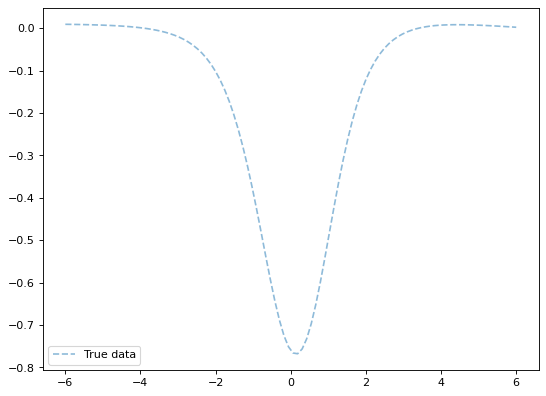

In [55]:
### Model result using epsilon loss function with penalty
print("Penalty lambda value = " + str(LAMBDA_PEN))
print("Interval is [{lb}, {ub}], with N_POINTS = {np}".format(lb=LOWER_BOUND, 
                                                              ub=UPPER_BOUND,
                                                              np=N_POINTS))
print("\n")

# Plot 1: The epsilon_loss with lambda penalty:
print("Plot 1: The epsilon_loss_with_penalty along the training epochs:")
x_epochs = graph_val_pen[0]
plot_figure(x_epochs, graph_val_pen[1])

print("\n")
# Plot 2: The epsilon_loss value when using train with penalty:
print("Plot 2: The epsilon_loss value along the training epochs:")

plot_figure(x_epochs, graph_val_pen[2])
print("\n")

# plot_figure(x_values, model_output)
# Plot 3: the model's output with input from the interval [LOWER_BOUND, UPPER_BOUND]:
print("Plot 3: the model's output with input from the interval: ")
x_vals = [torch.tensor([i], requires_grad=True, dtype=torch.float) for i in x_train]

model_output = []
for i in x_vals:
    model_output.append(model(i).detach().numpy().item())

plot_figure(x_values, model_output)

In [51]:
epsilon_Loss(given_fn, model, -6, 6, 1001)

tensor([23.2552], grad_fn=<MulBackward0>)

<Figure size 432x288 with 0 Axes>

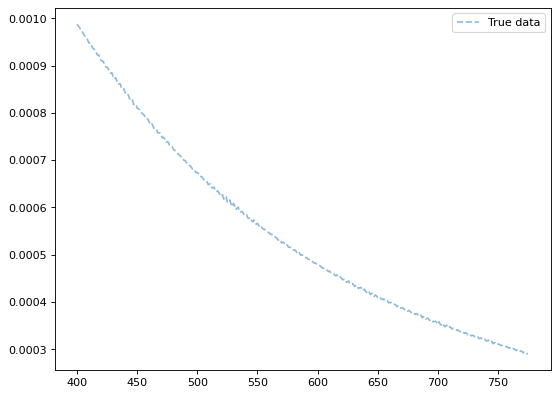

In [ ]:
diff = [None for i in range(len(graph_val_pen[2]))]
for i in range(len(graph_val_pen[2])):
    diff[i] = abs(graph_val_pen[2][i]-graph_val_pen[1][i])

plot_figure(x_epochs[400:], diff[400:])

<Figure size 432x288 with 0 Axes>

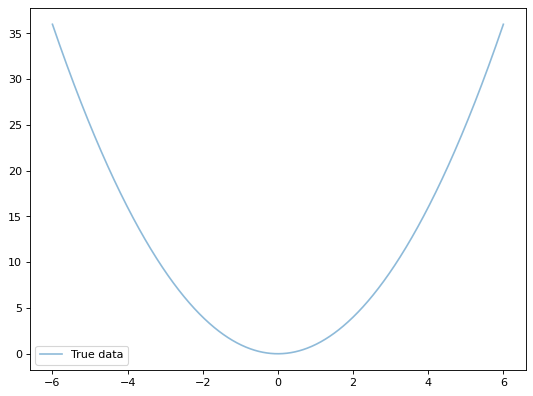

In [ ]:
plot_figure(x_train, y_train)

# HOW TO TRAIN THE NN MODEL:
1. Reset adam_optimizer: 
```adam_opt.zero_grad()```
2. Calculate loss
3. Update the optimizer: 
```adam_opt.step()```


        weight = weight - lr * gradient

-> use lr and gradient to "improve" weight layer. 

Explanation:
```adam_opt.step()```: Update the model's parameters 


In [ ]:
model_p = Nonlinear_2(4)
adam_opt = torch.optim.Adam(model_p.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

In [ ]:
x_i = torch.tensor([-2.5], requires_grad=True, dtype=torch.float)
u_xi = model_p(x_i)
print(u_xi)
u_xi.backward()
u_prime = x_i.grad

tensor([-0.5799], grad_fn=<AddBackward0>)


https://neptune.ai/blog/pytorch-loss-functions
https://stackoverflow.com/questions/53980031/pytorch-custom-loss-function
https://stackoverflow.com/questions/65947284/loss-with-custom-backward-function-in-pytorch-exploding-loss-in-simple-mse-exa
https://www.youtube.com/watch?v=ma2KXWblllc

In [56]:
a = float(input('enter lower limit of the domain: '))
b = float(input('enter upper limit of the domain: '))
N = int(input('enter number of grid points: '))

enter lower limit of the domain:  -6
enter upper limit of the domain:  6
enter number of grid points:  100


We have the linear system Ax = λx

Then decompose A into H + V, A = H+V

In [57]:
x = np.linspace(a,b,N)
h = x[1]-x[0]

In [58]:
c = np.sqrt(1/h)

In [59]:
c

2.8722813232690156

In [60]:
H = np.zeros((N,N))
# Question: Why H has dimension (N-2) x (N-2)?
V = np.zeros((N,N))

In [62]:
for i in range (N):
    for j in range (N):
        if i == j:
            H[i][j] = -2
        elif abs(i-j) == 1:
            H[i][j] = 1
print(H)

for i in range (N):
    for j in range (N):
        if i == j:
            V[i][j] = given_fn(x[i])
print(V)

[[-2.  1.  0. ...  0.  0.  0.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 0.  0.  0. ...  0.  1. -2.]]
[[36.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.         34.56014692  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         33.1496786  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 33.1496786   0.
   0.        ]
 [ 0.          0.          0.         ...  0.         34.56014692
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  36.        ]]


In [63]:
A = -H/(h**2) + V
print(A)

[[172.125      -68.0625       0.         ...   0.           0.
    0.        ]
 [-68.0625     170.68514692 -68.0625     ...   0.           0.
    0.        ]
 [  0.         -68.0625     169.2746786  ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 169.2746786  -68.0625
    0.        ]
 [  0.           0.           0.         ... -68.0625     170.68514692
  -68.0625    ]
 [  0.           0.           0.         ...   0.         -68.0625
  172.125     ]]


In [87]:
# Normalize eig_vec by computing L2 normeig_vec

In [64]:
eig_val, eig_vec = np.linalg.eig(A)
sorted_id_eig_val = np.argsort(eig_val)
# Get the indices that would sort eig_val
z = sorted_id_eig_val[0:1] # Bc. eig_val first 4 value is in ascending order, 
# eig_val[z] will return sorted first [T] value of eigenvalues.
energies = eig_val[z]/eig_val[z][0]

ground_state = c * eig_vec[:,z[0]]

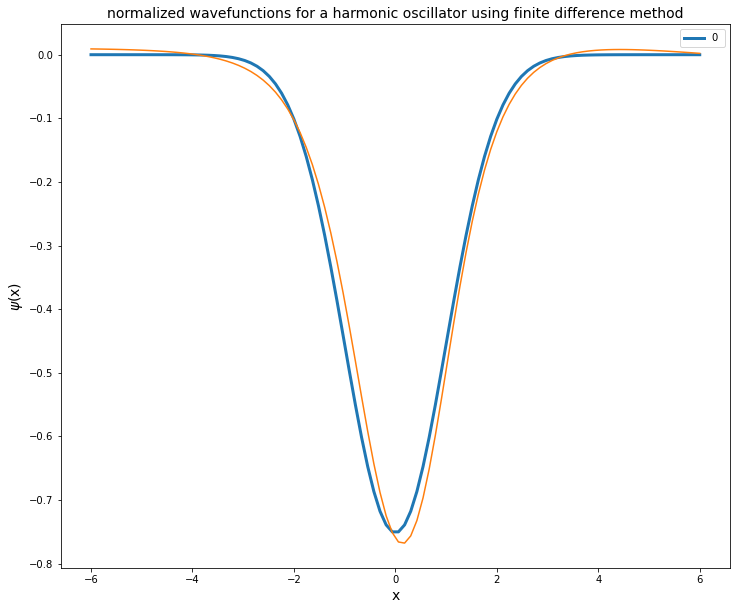

In [66]:
plt.figure(figsize=(12,10))
for i in range(len(z)):
    y = []
    y = np.append(y, (-1) * -ground_state)

#     print(y)
#     y = np.append(y,0)
#     print(y)
#     print(y)
#     y = np.insert(y,0,0)
#     print(y)
    plt.plot(x,y,lw=3, label="{} ".format(i))
    plt.xlabel('x', size=14)
    plt.ylabel('$\psi$(x)',size=14)
plt.plot(x_values, model_output)
plt.legend()
plt.title('normalized wavefunctions for a harmonic oscillator using finite difference method',size=14)
plt.show()